Epoch  0 MSE:  0.09227176755666733
Epoch  10 MSE:  0.05896216258406639
Epoch  20 MSE:  0.005944524891674519
Epoch  30 MSE:  0.0016674496000632644
Epoch  40 MSE:  0.0009414841188117862
Epoch  50 MSE:  0.0005683730123564601
Epoch  60 MSE:  0.00040055805584415793
Epoch  70 MSE:  0.00028279010439291596
Epoch  80 MSE:  0.0002423232508590445
Epoch  90 MSE:  0.00022165468544699252
Epoch  100 MSE:  0.0002077128883684054
Epoch  110 MSE:  0.00019872246775776148
Epoch  120 MSE:  0.00019120273645967245
Epoch  130 MSE:  0.00018442845612298697
Epoch  140 MSE:  0.00017805052630137652
Epoch  150 MSE:  0.00017192965606227517
Epoch  160 MSE:  0.0001661519636400044
Epoch  170 MSE:  0.00016135838814079762
Epoch  180 MSE:  0.00017838124767877162
Epoch  190 MSE:  0.00016122683882713318
Epoch  200 MSE:  0.00015294988406822085
Epoch  210 MSE:  0.00015066373453009874
Epoch  220 MSE:  0.0001463287917431444
Epoch  230 MSE:  0.00014371912402566522
Epoch  240 MSE:  0.0001413230347679928
Training time: 239.08998918

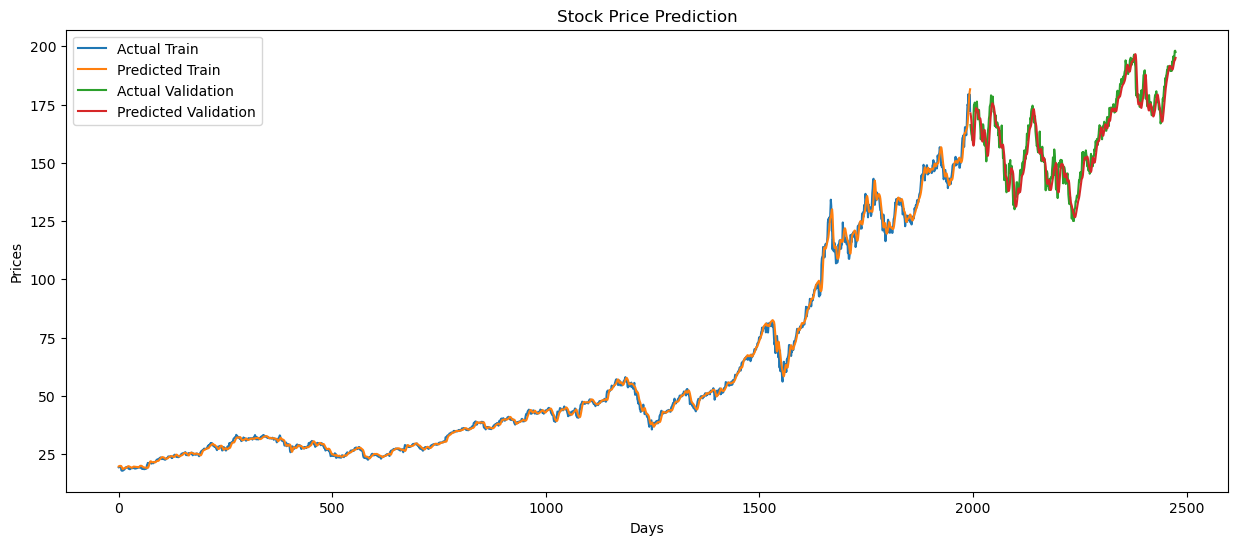

Final Assets: 675579.4719999995 Total Return: 175579.47199999948 Return Rate: 35.115894399999895 %


In [5]:
import torch
from torch import nn, optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import time
###### Set device: GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 数据预处理函数
def prepare_data(df, window, features):
    scaler = MinMaxScaler()
    df_features = df[features]
    df_features_scaled = scaler.fit_transform(df_features)
    scaler_target = MinMaxScaler()
    df_target_scaled = scaler_target.fit_transform(df[['Close']])

    x, y = [], []
    for i in range(len(df_features_scaled) - window):
        x.append(df_features_scaled[i:i+window, :])
        y.append(df_target_scaled[i + window, 0])

    return np.array(x), np.array(y), scaler, scaler_target

# 定义 LSTM 模型
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# 载入数据
# = r'C:\Users\John\Desktop\学习课件\数据科学开源工具\作业\期末作业\FinalProjectDemo\dataset\train.csv'
#val_data_path =  r'C:\Users\John\Desktop\学习课件\数据科学开源工具\作业\期末作业\FinalProjectDemo\dataset\val.csv'
train_data_path =  r'C:\Users\John\Desktop\学习课件\数据科学开源工具\作业\final project\AAPL_train.csv'
val_data_path =  r'C:\Users\John\Desktop\学习课件\数据科学开源工具\作业\final project\AAPL_test.csv'
train_data = pd.read_csv(train_data_path)
val_data = pd.read_csv(val_data_path)

# 选择的特征
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# 数据预处理
window = 20
x_train, y_train, scaler_train, scaler_target_train = prepare_data(train_data, window, features)
x_val, y_val, scaler_val, scaler_target_val = prepare_data(val_data, window, features)

# 转换为 PyTorch 张量
x_train_torch = torch.from_numpy(x_train).type(torch.Tensor)
y_train_torch = torch.from_numpy(y_train).type(torch.Tensor)
x_val_torch = torch.from_numpy(x_val).type(torch.Tensor)
y_val_torch = torch.from_numpy(y_val).type(torch.Tensor)

# 设置模型参数
num_epochs = 250
input_dim = len(features)  # 根据特征数量调整输入维度
hidden_dim = 128
num_layers = 5
output_dim = 1  # 预测输出一个值

# 声明模型
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

# 定义损失函数和优化器
criterion = nn.MSELoss(reduction='mean')  
optimiser = torch.optim.Adam(model.parameters(), lr=0.005)

# 训练模型
model.train()
hist = np.zeros(num_epochs)
start_time = time.time()
for t in range(num_epochs):
    y_train_pred = model(x_train_torch)
    loss = criterion(y_train_pred, y_train_torch.unsqueeze(1))
    if t % 10 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
print("Training time: {}".format(time.time() - start_time))

# 保存模型
torch.save(model.state_dict(), 'model.pth')

# 评估模型
model.eval()
y_train_pred = model(x_train_torch)
y_train_pred = scaler_target_train.inverse_transform(y_train_pred.detach().numpy())
y_train_actual = scaler_target_train.inverse_transform(y_train.reshape(-1, 1))

y_val_pred = model(x_val_torch)
y_val_pred = scaler_target_val.inverse_transform(y_val_pred.detach().numpy())
y_val_actual = scaler_target_val.inverse_transform(y_val.reshape(-1, 1))

# 可视化预测结果
plt.figure(figsize=(15, 6))
plt.plot(y_train_actual, label='Actual Train')
plt.plot(y_train_pred, label='Predicted Train')
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_val_actual)), y_val_actual, label='Actual Validation')
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_val_actual)), y_val_pred, label='Predicted Validation')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

# 回测函数
def backtest(predictions, original_prices, threshold=0.015, initial_cash=500000):
    cash = initial_cash
    shares = 0
    total_assets = initial_cash

    for i in range(1, len(predictions)):
        predicted_change = (predictions[i] - original_prices[i - 1]) / original_prices[i - 1]

        if predicted_change > threshold and cash >= original_prices[i]:
            shares_bought = cash // original_prices[i]
            shares += shares_bought
            cash -= shares_bought * original_prices[i]
        elif predicted_change < -threshold and shares > 0:
            cash += shares * original_prices[i]
            shares = 0
        total_assets = cash + shares * original_prices[i]

    total_return = total_assets - initial_cash
    return total_assets, total_return

initial_cash = 500000
threshold = 0.015

# 应用回测函数
final_assets, total_return = backtest(y_val_pred[:, 0], y_val_actual[:, 0], threshold=threshold, initial_cash=initial_cash)

# 计算回报率
return_rate = (total_return / initial_cash) * 100

print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:", return_rate, "%")

In [8]:
def classify_predictions(y_pred, y_true):
    """Classify predictions as 1 if there is an increase, 0 if a decrease or no change."""
    pred_diff = np.diff(y_pred.squeeze(), prepend=y_pred[0])
    true_diff = np.diff(y_true.squeeze(), prepend=y_true[0])
    return np.array(pred_diff > 0, dtype=int), np.array(true_diff > 0, dtype=int)
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score

y_val_class_pred, y_val_class_true = classify_predictions(y_val_pred, y_val_actual)

r2_val = r2_score(y_val_actual, y_val_pred)

print("R2 Score on Validation Data:", r2_val)


R2 Score on Validation Data: 0.9244624158874017


In [7]:
def classify_predictions(y_pred, y_true):
    """Classify predictions as 1 if there is an increase, 0 if a decrease or no change."""
    pred_diff = np.diff(y_pred.squeeze(), prepend=y_pred[0])
    true_diff = np.diff(y_true.squeeze(), prepend=y_true[0])
    return np.array(pred_diff > 0, dtype=int), np.array(true_diff > 0, dtype=int)

y_train_class_pred, y_train_class_true = classify_predictions(y_train_pred, y_train_actual)

r2_train = r2_score(y_train_actual, y_train_pred)
print("R2 Score on Training Data:", r2_train)

R2 Score on Training Data: 0.997616028554604
